# 1. Colab에 Mecab 설치

In [1]:
# Colab에 Mecab 설치
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 496.6/496.6 kB 44.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.8/588.8 kB 30.6 MB/s eta 0:00:00
  Created wheel for mecab-python: filename=mecab_python-1.0.0-py3-none-any.whl size=1232 sha256=fcfd71201b9ee654134eea2ffd2e46cc3e0d3b33de071b073dfd9f99802a8de7
  Stored in directory: /root/.cache/pip/wheels/a0/56/2c/eac72592ca2e80bdc46ff47d1fb327629e2a24e8cdc5aaf95f
Successfully built mecab-python
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0   500k      0  0:00:02  0:00:02 --:--:-- 1065k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example/exam

# 2. 네이버 쇼핑 리뷰 데이터에 대한 이해와 전처리

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f636a788050>)

In [4]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


In [5]:
total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [6]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [7]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [8]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


In [9]:
print(total_data.isnull().values.any())

False


In [10]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


# 3) 레이블의 분포 확인

<Axes: xlabel='label'>

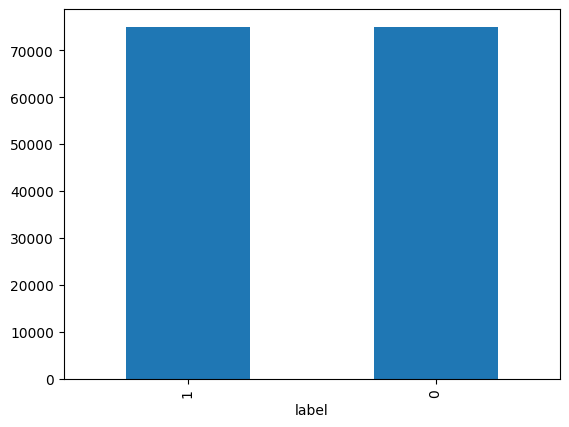

In [11]:
train_data['label'].value_counts().plot(kind = 'bar')

In [12]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  74918
1      1  75013


# 4) 데이터 정제하기

In [13]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


/tmp/ipython-input-2976499330.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['reviews'].replace('', np.nan, inplace=True)


In [14]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


/tmp/ipython-input-2684537507.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경


# 5) 토큰화

In [15]:
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [16]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']


In [17]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [18]:
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

# 6) 단어와 길이 분포 확인하기

In [19]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [20]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[(np.str_('.'), 77185), (np.str_('네요'), 31942), (np.str_('는데'), 20241), (np.str_('안'), 19757), (np.str_('어요'), 15232), (np.str_('있'), 13203), (np.str_('너무'), 12984), (np.str_('했'), 11888), (np.str_('좋'), 9804), (np.str_('배송'), 9681), (np.str_('..'), 9660), (np.str_('같'), 9005), (np.str_('어'), 8886), (np.str_('구매'), 8872), (np.str_('거'), 8868), (np.str_('아요'), 8679), (np.str_('없'), 8676), (np.str_('습니다'), 8443), (np.str_('그냥'), 8355), (np.str_('되'), 8349)]


In [21]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[(np.str_('좋'), 39455), (np.str_('.'), 35659), (np.str_('아요'), 21278), (np.str_('네요'), 19912), (np.str_('어요'), 19359), (np.str_('잘'), 18608), (np.str_('구매'), 16165), (np.str_('습니다'), 13340), (np.str_('있'), 12391), (np.str_('배송'), 12274), (np.str_('!'), 12007), (np.str_('는데'), 11685), (np.str_('했'), 10157), (np.str_('~'), 9980), (np.str_('합니다'), 9825), (np.str_('먹'), 9643), (np.str_('재'), 9268), (np.str_('너무'), 8388), (np.str_('같'), 7870), (np.str_('만족'), 7250)]


긍정 리뷰의 평균 길이 : 14.788569981203258
부정 리뷰의 평균 길이 : 18.835380015483594


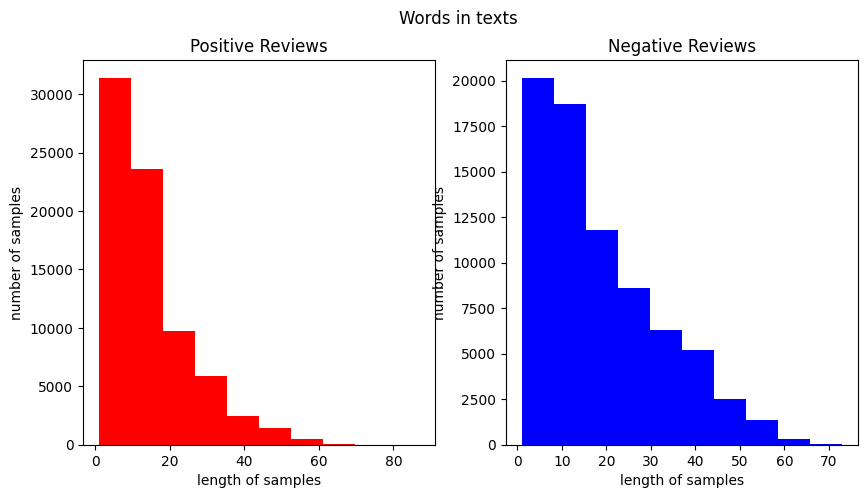

In [22]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [23]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

# 7) 정수 인코딩

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [25]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 42361
등장 빈도가 1번 이하인 희귀 단어의 수: 19707
단어 집합에서 희귀 단어의 비율: 46.521564646726944
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7818860486485715


In [26]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 22656


In [27]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [28]:
print(X_train[:3])

[[72, 146, 2083, 313, 14803, 278, 79, 7, 254, 182, 148, 835, 3046, 659, 3, 85, 68, 219, 44, 1402, 168, 4, 7], [509, 2795, 2, 2, 8834, 2686, 2, 2, 2543, 353, 3017, 266, 2424, 41, 495, 3], [50, 27, 881, 104, 39, 2425, 171, 8, 11, 8343, 5, 2, 1375, 34, 149, 335, 46, 64, 171, 149, 8, 1980, 3, 2, 4629, 121, 177, 1443, 292, 45, 33, 130, 147, 2, 4629]]


In [29]:
print(X_test[:3])

[[15, 740, 803, 125, 198, 264, 14], [353, 4058, 68, 4159, 1705], [13, 77, 3, 54, 176, 4, 30, 16, 7, 398, 538, 304, 18, 101, 120, 611, 64, 8, 3]]


# 8) 패딩

리뷰의 최대 길이 : 87
리뷰의 평균 길이 : 16.81069291874262


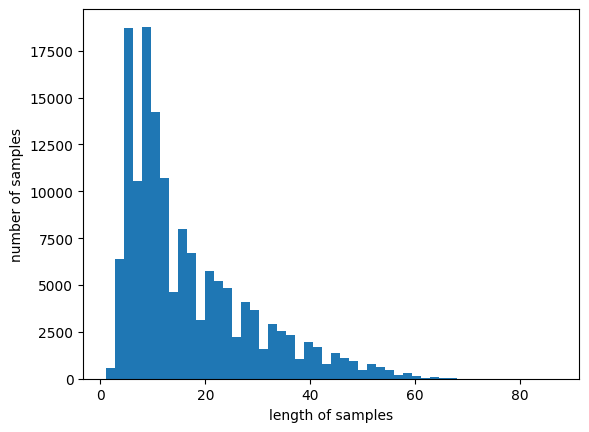

In [30]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [31]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [32]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99866605305107


In [33]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# 3. LSTM 학습으로 쇼핑 리뷰 감성 분류하기

In [34]:
from tensorflow.keras.layers import Embedding, Dense, GRU, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
#model.add(GRU(hidden_units))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
#mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
mc = ModelCheckpoint('best_model.keras', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8505 - loss: 0.3527
Epoch 1: val_acc improved from -inf to 0.91380, saving model to best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - acc: 0.8507 - loss: 0.3524 - val_acc: 0.9138 - val_loss: 0.2388
Epoch 2/15
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9177 - loss: 0.2306
Epoch 2: val_acc improved from 0.91380 to 0.92130, saving model to best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - acc: 0.9177 - loss: 0.2305 - val_acc: 0.9213 - val_loss: 0.2203
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9286 - loss: 0.2043
Epoch 3: val_acc improved from 0.92130 to 0.92333, saving model to best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - acc: 0.9286 - loss: 0.2043 - val_acc: 0.9233 - val_loss: 0.2105
Epoch 4/15
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9346 - loss: 0.1885
Epoch 4: val_acc improved from 0.92333 to 0.92377, saving model to best_model.keras
1875/

In [35]:
# Original Code
# loaded_model = load_model('best_model.h5')

# Changed Code
# Load the model using the correct filename 'best_model.keras'
loaded_model = load_model('best_model.keras')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - acc: 0.9242 - loss: 0.2138

 테스트 정확도: 0.9229


# 4. 리뷰 예측해보기

In [36]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [37]:
sentiment_predict('상품 구매 했는데.. 완전 노잼')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
81.05% 확률로 부정 리뷰입니다.


/tmp/ipython-input-378981754.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))


In [38]:
sentiment_predict('판매자님... 너무 짱이에요.. 대박나삼')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
96.75% 확률로 긍정 리뷰입니다.


/tmp/ipython-input-378981754.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))


In [39]:
sentiment_predict('배송빠른데, 상품 품질은 별로에요. 사진과 달리 너무 작어요')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
99.89% 확률로 부정 리뷰입니다.


/tmp/ipython-input-378981754.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))


In [40]:
sentiment_predict('배송빨라서 너무 좋아요 근데, 상품 품질은 별로에요. 사진과 달리 너무 작어요')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
88.99% 확률로 부정 리뷰입니다.


/tmp/ipython-input-378981754.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))


In [41]:
sentiment_predict('배송빨라서 너무 좋아요 근데, 상품 품질은 별로에요')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
77.70% 확률로 부정 리뷰입니다.


/tmp/ipython-input-378981754.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))


In [42]:
sentiment_predict('상품 품질은 좋아요   가격은 비싼편이네요  ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
82.38% 확률로 긍정 리뷰입니다.


/tmp/ipython-input-378981754.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))


In [43]:
sentiment_predict('상품은 별로인데.. 배송은 빨라요  ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
72.91% 확률로 부정 리뷰입니다.


/tmp/ipython-input-378981754.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))


In [44]:
sentiment_predict('상품이 파손되어서 왔어요.. 상품은괜찮은데. 배송이 문제네요  ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
98.95% 확률로 부정 리뷰입니다.


/tmp/ipython-input-378981754.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))


In [45]:
sentiment_predict('정말 빨라요.. 상품 박스가 . 손상되었어요..  ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
65.51% 확률로 부정 리뷰입니다.


/tmp/ipython-input-378981754.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))
